---
title: keras教程-n-图片风格转换理论和实践
date: 2018-10-31 20:17:55
tags: [keras教程]
toc: true
xiongzhang: false

---
<span></span>
<!-- more -->


本文代码运行环境:

- windows10
- python3.6
- jupyter notebook
- tensorflow 1.x
- keras 2.x

这必须是最酷的机器学习实现之一。如果你不知道什么是`neural style transfer`，它的大概意思就是将一个图片的内容和两个图片的风格融合构成一个新的图片。

例如:

<img src="images/style-trans.png" />


在本教程中，我们将学习如何使用深度学习将图片的风格进行转换。这被称为`neural style transfer`！这是Leon A. Gatys的论文“A Neural Algorithm of Artistic Style,”中概述的一种技术，这个论很好，你一定要看看它:https://arxiv.org/abs/1508.06576

Neural style transfer is an optimization technique used to take three images, a content image, a style reference image (such as an artwork by a famous painter), and the input image you want to style — and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

Neural style transfer的原理是定义两个距离函数，一个描述两个图像的内容有多么不同，$L_{content}$，一个描述两个图像之间的风格$L_{style}$之间的差异有多大。然后，给定三个图像，提供样式风格的图像，提供内容的图像和输入图像（用内容图像初始化），我们尝试变换输入图像以最小化与内容图像的内容距离及与风格图像的风格样式距离。

### 总体步骤

- 数据的准备
- 定义损失函数
- 构建模型(使用预训练权重)
- 训练模型

本篇文章主要面向使用过keras的人, 大约阅读实践50分钟。

#### 关于VGG19

如果你自己训练过类似的模型, 你就会发现, 想要得到一个良好的风格转换模型是需要很长的训练时间的, 所以我们可以使用一些预训练模型。最流行的图片分类预训练模型就是VGG, 它是由Oxford的一些人在ImageNet数据集上训练得到的。原始版的VGG使用了Caffe进行训练, 所以没法直接在Tensorflow中直接使用。不过, Keras提供了一个VGG19的类, 它可以下载官方支持的Keras权重。

### 代码实现

引入用到的库并设置图片的高和宽:

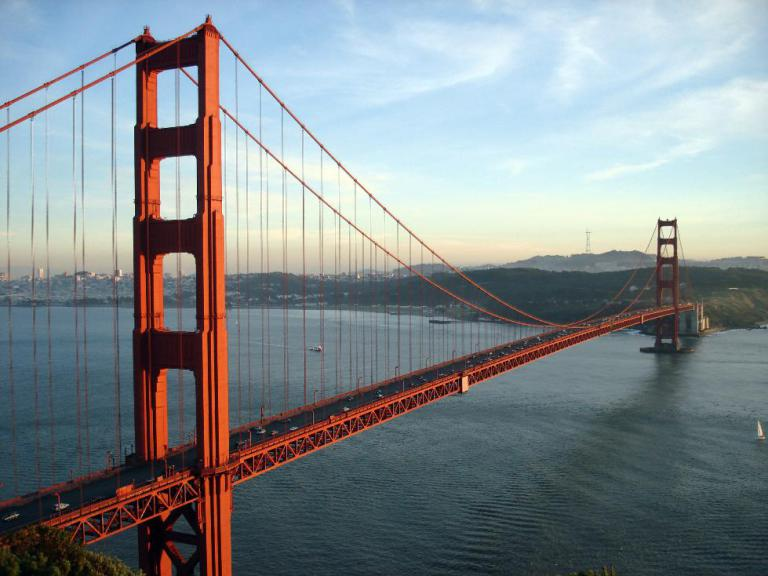

In [43]:
import numpy as np
import tensorflow.contrib.keras.api.keras.backend as K
from scipy.misc import imsave, imresize
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.applications import vgg19
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image

# 图片的高和宽
img_h = 80
img_w = 100

# 两张图片
CONTENT_IMG_PATH = './images/content.jpg'
STYLE_IMG_PATH = './images/style.jpg'

Image(filename=CONTENT_IMG_PATH, width='200', height='180')


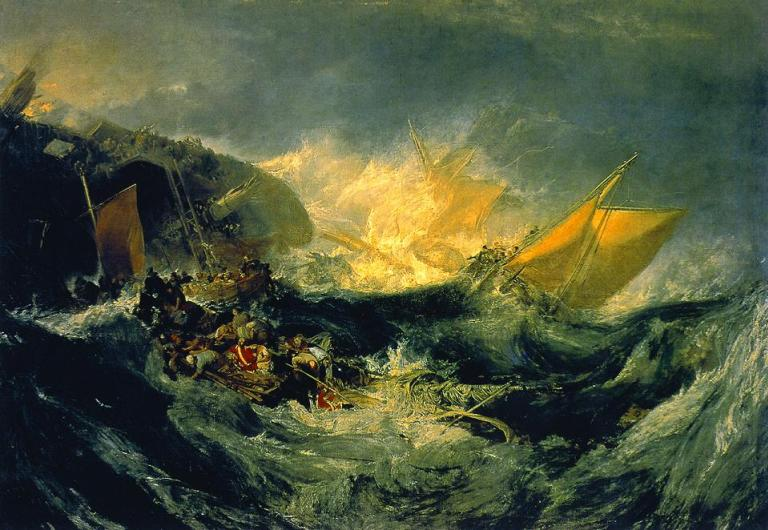

In [44]:
Image(filename=STYLE_IMG_PATH, width='200', height='180')

#### 准备数据


图片预处理

In [30]:
def preprocess(img_path):
    img = load_img(img_path)
    img = img_to_array(img)
    # 图片缩放到设置的大小
    img = imresize(img, (img_h, img_w, 3))
    img = img.astype('float64')
    # 增加一个维度, 为了将三张图片在这个维度上合并
    img = np.expand_dims(img, axis=0)
    # 图片处理成vgg模型需要的
    img = vgg19.preprocess_input(img)
    return img


# 只是为了测试
print(preprocess(CONTENT_IMG_PATH).shape)

(1, 80, 100, 3)


d:\mysites\deeplearning.ai-master\.env\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


#### 构建输入张量并下载模型

In [5]:

content_img = K.variable(preprocess(CONTENT_IMG_PATH))
style_img = K.variable(preprocess(STYLE_IMG_PATH))
gen_img = K.placeholder(shape=(1, img_h, img_w, 3))
# 注意: 三个图片构成一个输入张量, 而每个图像所在位置要记住
input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)

model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
print('Model loaded')

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


d:\mysites\deeplearning.ai-master\.env\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


80142336/80134624 [==============================] - 70s 1us/step
Model loaded


我们可以大概看一下预训练的模型的基本结构:

In [6]:
outputs_dict

{'input_1': <tf.Tensor 'concat:0' shape=(3, 80, 100, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 80, 100, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 80, 100, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 40, 50, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 40, 50, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 40, 50, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 20, 25, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 20, 25, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 20, 25, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 20, 25, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 20, 25, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_po

#### 定义损失函数

损失函数是这个教程最重要的部分,它决定了你是否能理解这个风格转换模型。所以, 让我们亲手把损失函数写出来:

##### 内容损失函数

内容损失函数只是对应像素值的差值的平方和(具体内容看注释):

In [8]:
# 内容图片和生成图片的像素点数值的差的平方和
def content_loss(content, gen):
    return K.sum(K.square(gen-content))

In [11]:
# 内容损失权重
CONTENT_WEIGHT  = 0.025
# 初始损失值为0
loss = 0.
# 我们并不是选择最后一层作为输出层
# 因为我们希望提取的是一些基本特征, 比如直线/斜线等
# 而越靠后的层的特征越倾向于识别更宏观的特征, 比如眼睛
layer_features = outputs_dict['block5_conv2']
# 内容图片位于第一
content_img_features = layer_features[0, :, :, :]
# 生成的图片位于最后
gen_img_features = layer_features[2, :, :, :]
# 损失值是需要加权的
loss += CONTENT_WEIGHT * content_loss(content_img_features, gen_img_features)

##### 风格损失函数

风格损失函数有点复杂, 它需要用到gram矩阵, 它是衡量特征之间的相关关系, 所以风格损失函数就是为了最小化风格图片和生成图片之间的特征相关矩阵的欧式距离。

- K.batch_flatten: 将一个n阶张量转变为2阶张量，其第一维度保留不变
- K.permute_dimensions: 转置
- gram matrix: 编码了不同特征之间的相关关系

In [12]:

def gram_matrix(x):
    assert K.ndim(x) == 3
    # 将一个3阶张量转变为2阶张量，其第一维度保留不变
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, gen):
    assert K.ndim(style) == 3
    assert K.ndim(gen) == 3
    S = gram_matrix(style)
    G = gram_matrix(gen)
    channels = 3
    size = img_h * img_w
    return K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2))

In [14]:
# 注意加权
STYLE_WEIGHT = 1
feature_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
for name in feature_layer_names:
    layer_features = outputs_dict[name]
    style_features = layer_features[1, :, :, :]
    gen_img_features = layer_features[2, :, :, :]
    s1 = style_loss(style_features, gen_img_features)
    loss += (STYLE_WEIGHT / len(feature_layer_names)) * s1

##### 方差损失

还是有第三个损失函数, 是为了使生成的图片平滑, 减少噪音的产生, 具体看注释:

In [31]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    # 纵向 相邻像素点差值的平方
    a = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, 1:, :img_w - 1, :])
    # 横向 相邻像素点差值的平方
    b = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, :img_h - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

所有的损失加和:

In [17]:
TV_WEIGHT = 1
loss += TV_WEIGHT * total_variation_loss(gen_img)

#### 梯度和损失

梯度很容易计算。我们只是将生成的图像和损失函数传递给K.gradients（）函数即可。

我们还需要定义一个Keras函数，用于计算优化过程中的损失和梯度。


In [18]:
grads = K.gradients(loss, gen_img)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_output = K.function([gen_img], outputs)


def eval_loss_and_grads(x):
    x = x.reshape((1, img_h, img_w, 3))
    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values


In [27]:
evaluator = Evaluator()

# Run L-BFGS optimizer
x = preprocess(CONTENT_IMG_PATH)

x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxiter=100)
print('    loss: {}'.format(min_val))
# Save img
# print(x.reshape(img_h, img_w, 3))
img = x.reshape(img_h, img_w, 3)
imsave('./output/img0.jpg', img)

d:\mysites\deeplearning.ai-master\.env\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


    loss: 1516893568.0


d:\mysites\deeplearning.ai-master\.env\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()


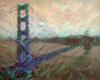

In [39]:

Image(filename = './output/img0.jpg')